
<center>

# **PREDICTIVE METHOD:** 
# **RANDOM FOREST CLASSIFIER - WITH UMAP** 
by: Ly Nguyen

<center>

In [1]:
# Import necessary libraries for this notebook: 

# Read from SQLite database and load to a pandas dataframe
import os
import sqlite3
import pandas as pd

# For using arrays 
import numpy as np

# For ML work (data preprocessing, hyperparameter tuning, Random Forest Classifier, training & testing sets, and stratified sampling)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight


# For Dimensionality Reduction
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

# For model evaluation, including explainability:  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, balanced_accuracy_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
import statsmodels.api as sm
import shap

# For data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# For saving the model into a pkl file
import joblib



c:\ProgramData\miniconda3\envs\DSI_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the saved df_prelim parquet file: 
relative_path = os.path.join("..", "src", "df_reduced.parquet")
df_reduced = pd.read_parquet(relative_path)

In [3]:
# Define X and y:
X = df_reduced.drop(columns=['delayType'])  # Use parentheses with the 'columns' argument
y = df_reduced['delayType']


### *STANDARD SCALE THE FEATURES*

In [4]:

# Standardize the features for UMAP & PCA 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP

In [5]:
# Apply UMAP to reduce dimensions
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)

# Convert to DataFrame for easier handling
X_umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
print(X_umap_df.head())



n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
Graph is not fully connected, spectral embedding may not work as expected.


       UMAP1      UMAP2
0  -2.767221  -4.742128
1 -14.542651  11.676364
2  -4.419547  -5.541454
3  -0.909556   0.050427
4   4.640318  11.677635


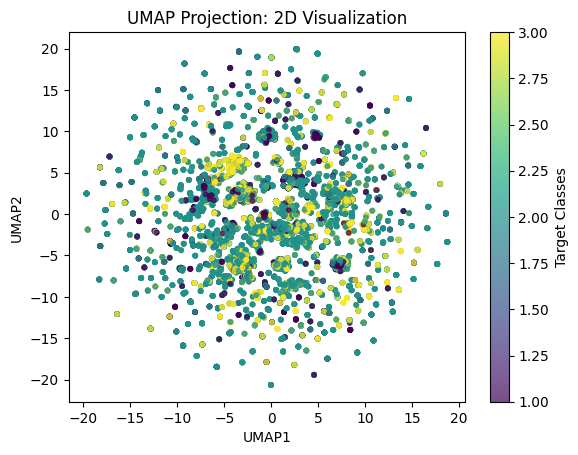

In [6]:
# Scatter plot of UMAP-transformed data
import matplotlib.pyplot as plt

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='Target Classes')
plt.title('UMAP Projection: 2D Visualization')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


In [7]:
# Apply UMAP with more dimensions
umap_reducer = umap.UMAP(n_components=10, random_state=42)
X_umap_high = umap_reducer.fit_transform(X_scaled)

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
Graph is not fully connected, spectral embedding may not work as expected.


In [8]:
# Stratified sampling to split the UMAP-transformed data
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(X_umap_high, y, test_size=0.3, random_state=42, stratify=y)

# Apply balanced class weights on the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_umap),
    y=y_train_umap
)
class_weight_dict = dict(zip(np.unique(y_train_umap), class_weights))

# Define a Random Forest Classifier
rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)

# Define hyperparameter grid for Random Forest tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    }

# Apply stratified sampling on cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a scorer for balanced accuracy
scorer = make_scorer(balanced_accuracy_score)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit the model on training data
grid_search.fit(X_train_umap, y_train_umap)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [9]:
# Get the best estimator after GridSearchCV
best_rf_umap = grid_search.best_estimator_

In [10]:
# Evaluate the model on the test set
y_pred_umap = best_rf_umap.predict(X_test_umap)

In [11]:
# Classification report
print("Classification Report:\n", classification_report(y_test_umap, y_pred_umap))

# Balanced accuracy score
balanced_acc = balanced_accuracy_score(y_test_umap, y_pred_umap)
print(f"\nBalanced Accuracy: {balanced_acc:.2f}")


Classification Report:
               precision    recall  f1-score   support

           1       0.33      0.55      0.41       583
           2       0.82      0.61      0.70      3832
           3       0.40      0.61      0.48      1056

    accuracy                           0.61      5471
   macro avg       0.51      0.59      0.53      5471
weighted avg       0.69      0.61      0.63      5471


Balanced Accuracy: 0.59


# **Observation:**
- This 4th model performs worse than the 3rd model across the scores. 
- The 3rd model is the optimal one so far.

---
---